# kubeflow, seldon-core example - train and deploy ML on Kubernetes


## Install Tools
Deploy kubeflow and seldon-core with [ksonnet](https://ksonnet.io/)

 1. Create a GCP Cluster
 1. Setup kubeflow and seldon-core
```bash
ks init k8s_tools --api-spec=version:v1.8.0
cd k8s_tools
ks registry add kubeflow github.com/kubeflow/kubeflow/tree/master/kubeflow 
ks pkg install kubeflow/core 
ks pkg install kubeflow/tf-serving 
ks pkg install kubeflow/tf-job 
kubectl create clusterrolebinding default-admin --clusterrole=cluster-admin --user=cc@seldon.io
ks generate core kubeflow-core --name=kubeflow-core
ks registry add seldon-core github.com/SeldonIO/seldon-core/tree/master/seldon-core
ks pkg install seldon-core/seldon-core
ks generate seldon-core seldon-core --withApife=false --withRbac=true
```


## MNIST Example
![MNIST](mnist.png "MNIST Digits")

In [19]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
def gen_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d,cmap=plt.cm.gray_r, interpolation='nearest')
    return plt

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


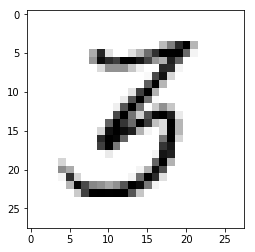

In [20]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
batch_xs, batch_ys = mnist.train.next_batch(10)
gen_image(batch_xs[1]).show()

## Train model

Tensorflow code to train a simple MNIST classifier.

```python
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
import tensorflow as tf

if __name__ == '__main__':
    
    x = tf.placeholder(tf.float32, [None,784], name="x")

    W = tf.Variable(tf.zeros([784,10]))
    b = tf.Variable(tf.zeros([10]))

    y = tf.nn.softmax(tf.matmul(x,W) + b, name="y")

    y_ = tf.placeholder(tf.float32, [None, 10])


    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

    init = tf.initialize_all_variables()

    sess = tf.Session()
    sess.run(init)

    for i in range(1000):
        batch_xs, batch_ys = mnist.train.next_batch(100)
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print(sess.run(accuracy, feed_dict = {x: mnist.test.images, y_:mnist.test.labels}))

    saver = tf.train.Saver()

    saver.save(sess, "/data/deep_mnist_model")
```

Create docker image for training. Work in progres to do this via Argo.
```bash
kubeflow-seldon-example/model/train
docker build --force-rm=true -t seldonio/deepmnistclassifier_trainer:0.1 .
```

In [57]:
!cat ../k8s_train/tfJob.json | jq .

{
  "apiVersion": "tensorflow.org/v1alpha1",
  "kind": "TfJob",
  "metadata": {
    "name": "mnist-train",
    "namespace": "default"
  },
  "spec": {
    "replicaSpecs": [
      {
        "replicas": 1,
        "template": {
          "spec": {
            "containers": [
              {
                "image": "seldonio/deepmnistclassifier_trainer:0.1",
                "name": "tensorflow",
                "volumeMounts": [
                  {
                    "mountPath": "/data",
                    "name": "persistent-storage"
                  }
                ]
              }
            ],
            "restartPolicy": "OnFailure",
            "volumes": [
              {
                "name": "persistent-storage",
                "persistentVolumeClaim": {
                  "claimName": "ml-data"
                }
              }
            ]
          }
        },
        "tfReplicaType": "MASTER"
      }
    ]
  }
}


In [ ]:
!kubectl apply ../k8s_train/tfJob.json

## Runtime Serving
Create runtime python module that respects seldon-core microservice template.

```python
import tensorflow as tf

class DeepMnist(object):
    def __init__(self):
        self.class_names = ["class:{}".format(str(i)) for i in range(10)]
        self.sess = tf.Session()
        saver = tf.train.import_meta_graph("/data/deep_mnist_model.meta")
        saver.restore(self.sess,tf.train.latest_checkpoint("/data/"))

        graph = tf.get_default_graph()
        self.x = graph.get_tensor_by_name("x:0")
        self.y = graph.get_tensor_by_name("y:0")

    def predict(self,X,feature_names):
        predictions = self.sess.run(self.y,feed_dict={self.x:X})
        return predictions
```

Wrap model using seldon-core wrappers for python. Work in progress to do this via Argo.
```bash
cd kubeflow-seldon-example/model/runtime
docker run -v  ${PWD}:/my_model seldonio/core-python-wrapper:0.6 /my_model DeepMnist 0.1 seldonio --image-name=deepmnistclassifier_runtime
```

In [58]:
!cat ../k8s_serving/serving_model.json | jq .

{
  "apiVersion": "machinelearning.seldon.io/v1alpha1",
  "kind": "SeldonDeployment",
  "metadata": {
    "labels": {
      "app": "seldon"
    },
    "name": "mnist-classifier"
  },
  "spec": {
    "annotations": {
      "deployment_version": "v1",
      "project_name": "MNIST Example"
    },
    "name": "mnist-classifier",
    "oauth_key": "oauth-key",
    "oauth_secret": "oauth-secret",
    "predictors": [
      {
        "annotations": {
          "predictor_version": "v1"
        },
        "componentSpec": {
          "spec": {
            "containers": [
              {
                "image": "seldonio/deepmnistclassifier_runtime:0.1",
                "imagePullPolicy": "Always",
                "name": "mnist-classifier",
                "volumeMounts": [
                  {
                    "mountPath": "/data",
                    "name": "persistent-storage"
                  }
                ]
              }
            ],
            "terminationGracePeriodSeconds":

## Get predictions

Illustration of both REST and gRPC requests. 

In [8]:
import requests
from requests.auth import HTTPBasicAuth
import commands
from random import randint,random

AMBASSADOR_API_IP=commands.getoutput("kubectl get svc ambassador -o jsonpath='{.status.loadBalancer.ingress[0].ip}'")

def rest_request(deploymentName,data):
    payload = {"data":{"ndarray":data.tolist()}}
    response = requests.post(
                "http://"+AMBASSADOR_API_IP+"/seldon/"+deploymentName+"/api/v0.1/predictions",
                json=payload)
    print response.status_code
    print response.text   
    
    
def rest_request_auth(deploymentName,data,username,password):
    payload = {"data":{"ndarray":data.tolist()}}
    response = requests.post(
                "http://"+AMBASSADOR_API_IP+"/seldon/"+deploymentName+"/api/v0.1/predictions",
                json=payload,
                auth=HTTPBasicAuth(username, password))
    print response.status_code
    print response.text   


#### REST Request

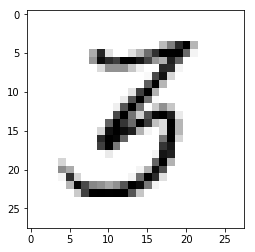

200
{
  "meta": {
    "puid": "rlj8p7s9abm7p36uq0a351mmsd",
    "tags": {
    },
    "routing": {
    }
  },
  "data": {
    "names": ["class:0", "class:1", "class:2", "class:3", "class:4", "class:5", "class:6", "class:7", "class:8", "class:9"],
    "ndarray": [[0.004430549684911966, 0.0029370638076215982, 0.025882113724946976, 0.8161398768424988, 0.0011041491525247693, 0.07343751192092896, 0.004165350459516048, 3.6722929507959634E-5, 0.07055757939815521, 0.0013090643333271146]]
  }
}


In [21]:
chosen=1
gen_image(batch_xs[chosen]).show()
rest_request("mnist-classifier",batch_xs[chosen].reshape((1,784)))

## Adding Authentication
We will add the example authentication from the Ambassador tutorial which show basic authentication. Work in progress to add oauth2 or GCP IAP.

In [22]:
!kubectl apply -f ../k8s_serving/ambassador-auth-service-setup.yaml

service "example-auth" unchanged
deployment "example-auth" configured


** Need to wait until running before adding Ambassador config **

In [23]:
!kubectl get pods

NAME                                                READY     STATUS    RESTARTS   AGE
ambassador-d96567548-hlvzl                          2/2       Running   0          1d
ambassador-d96567548-s7bsp                          2/2       Running   0          1d
ambassador-d96567548-xql8k                          2/2       Running   0          1d
example-auth-6f4877965f-s2l22                       1/1       Running   0          14h
mnist-classifier-mnist-classifier-c677c9d69-9dfgs   2/2       Running   0          1d
redis-6668b544f4-nfsgz                              1/1       Running   0          1d
seldon-cluster-manager-559894469d-wkp7c             1/1       Running   0          1d
tf-hub-0                                            1/1       Running   0          1d
tf-job-dashboard-59fcb66998-8gjsf                   1/1       Running   0          1d
tf-job-operator-55b9c748b8-g8qkp                    1/1       Running   0          1d


In [24]:
!kubectl apply -f ../k8s_serving/ambassador-auth-service-config.yaml

service "example-auth" configured


Show failed request when auth is running

In [25]:
rest_request("mnist-classifier",batch_xs[1].reshape((1,784)))

401



Show successful request with auth

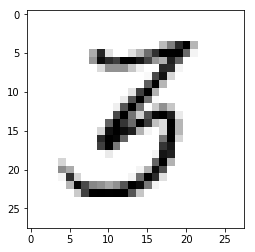

200
{
  "meta": {
    "puid": "1v8qdv5c93ka1rr66lgds61srp",
    "tags": {
    },
    "routing": {
    }
  },
  "data": {
    "names": ["class:0", "class:1", "class:2", "class:3", "class:4", "class:5", "class:6", "class:7", "class:8", "class:9"],
    "ndarray": [[0.004430549684911966, 0.0029370638076215982, 0.025882113724946976, 0.8161398768424988, 0.0011041491525247693, 0.07343751192092896, 0.004165350459516048, 3.6722929507959634E-5, 0.07055757939815521, 0.0013090643333271146]]
  }
}


In [26]:
chosen=1
gen_image(batch_xs[chosen]).show()
rest_request_auth("mnist-classifier",batch_xs[chosen].reshape((1,784)),"username","password")

Remove auth

In [27]:
!kubectl delete -f ../k8s_serving/ambassador-auth-service-setup.yaml

service "example-auth" deleted
deployment "example-auth" deleted
